In [1]:
import pandas as pd
import sys,os
import random

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '..')

from unpast.utils.io import read_bic_table
from unpast.utils.method import zscore
from unpast.utils.eval import calculate_perfromance

In [2]:
bic_path = "../../outputs/"
data_path = "../data/asthma/"
img_path = "../../img/Fig3/"

### Reading annotation and expression,
prepareing inputs for calculate_perfromance()

In [4]:
exprs_file = data_path+"/asthma_GSE4302.RMA.maxRowVariance.log2exprs.tsv.gz"
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

anno  = pd.read_csv(data_path+"/asthma_GSE4302.annot.tsv.gz",sep="\t",index_col=0)
anno.head(3)
all_samples = set(exprs.columns).intersection(set(anno.index))

In [5]:
exprs.shape

(18317, 118)

In [6]:
known_groups = {"Th2 asthma":{"Th2-high": set(anno.loc[anno["Th2 asthma"]==1,:].index.values)}}
known_groups["Th2 asthma"].keys()

dict_keys(['Th2-high'])

In [7]:
len(known_groups["Th2 asthma"]["Th2-high"] )

37

### UnPaSt results

In [9]:
unpast_biclusters = read_bic_table(bic_path+"/GSE4302/UnPaSt/optimized_ARI/asthma_GSE4302.seed=42.consensus.biclusters.tsv")

In [10]:
performance, best_matches = calculate_perfromance(unpast_biclusters, 
                                                  known_groups, 
                                                  all_samples, 
                                                  adjust_pvals = "BH",
                                                  performance_measure = "ARI")
print("Performance:",performance[0])
best_matches

Performance: 0.8650702286636647


,ARI,adj_pval,bm_id,is_enriched,n_samples,samples,weight,classification
Th2-high,0.86507,0.00001,22,True,35,"{GSM98153, GSM98188, GSM98171, GSM98145, GSM98...",1.0,Th2 asthma


In [11]:
bm_id = best_matches.loc[:,"bm_id"][0]
genes = unpast_biclusters.loc[bm_id,"genes"]
bm_id

22

<Figure size 432x288 with 0 Axes>

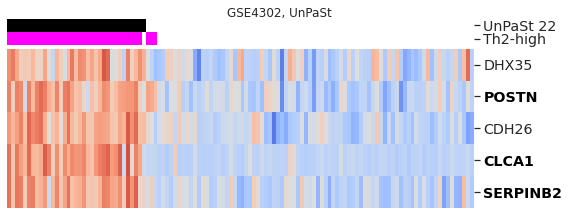

In [13]:
from unpast.utils.figs import draw_heatmap2
from collections import OrderedDict

a = anno.loc[:,["asthma","sample type:ch1","Th2 asthma"]]
a.loc[a["asthma"]==1,"asthma"] = "Asthma"
a.loc[a["asthma"]==0,"asthma"] = "Healthy"

a = a.loc[:,["Th2 asthma"]]
a.columns = ["Th2-high"]
a.loc[a["Th2-high"]==1,"Th2-high"] = "Th2-high"
a.loc[a["Th2-high"]==0,"Th2-high"] = "Th2-low"

sns.set(font_scale=1.3)
# selecting colors
color_dict = OrderedDict()

color_dict["Th2-high"] = OrderedDict()
color_dict["Th2-high"]["Th2-high"] = "magenta"
color_dict["Th2-high"]["Th2-low"] = "white"

plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(exprs.loc[sorted(genes),:],
                                                            unpast_biclusters.loc[[bm_id],:],
                 annot=a,
                 color_dict=color_dict,
                 figsize = (8,3),
                 dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0,0.07),
                 legend_n_cols=0,
                 no_cbar=True,
                 cluster_rows=True,
                 xlabel = "",
                 col_labels = False,
                 row_labels = True,
                 highlight_row_labels=["POSTN","CLCA1","SERPINB2"],
                 #col_range=(-3,3),
                 bic_prefix = "UnPaSt ")
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
tmp = sns_plot.fig.suptitle('GSE4302, UnPaSt') 

fig_name = "Fig3_E_GSE4302_UnPaSt"
for ext in ["png","pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

In [56]:
cseed = 42
n_runs = 5
seeds = []
random.seed(cseed)
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
    seed = seeds[i]
    fname = "asthma_GSE4302.seed="+str(seed)+".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"
    #unpast_biclusters = read_bic_table("../../results_on_real_data_tuned_v2/optimized_GSE4302/"+fname)
    unpast_biclusters = read_bic_table(bic_path+"/GSE4302/UnPaSt/optimized_ARI/"+fname)
    
    performance, best_matches = calculate_perfromance(unpast_biclusters, known_groups, set(anno.index.values))
    bm_id = best_matches["bm_id"].values[0]
    print("\t".join([str(seed),str(performance[0]),
                     " ".join(sorted(unpast_biclusters.loc[bm_id,"genes"]))
                    ]))




670487	0.8974358974358975	CDH26 POSTN SERPINB2
116739	0.8947368421052632	CDH26 CLCA1 DHX35 POSTN SERPINB2
26225	0.8974358974358975	CDH26 POSTN SERPINB2
777572	0.8947368421052632	CDH26 CLCA1 DHX35 POSTN SERPINB2
288389	0.8974358974358975	CDH26 DHX35 POSTN SERPINB2


####  plot legend  

<Figure size 432x288 with 0 Axes>

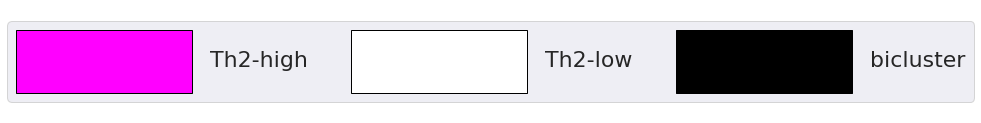

In [14]:
from matplotlib.patches import Patch
sns.set()

plt.figure()
legend_elements = []

for subt in color_dict["Th2-high"].keys():
    p = Patch(facecolor=color_dict["Th2-high"][subt], edgecolor='black', label=subt)
    legend_elements.append(p)
    
p = Patch(facecolor="black", edgecolor='black', label="bicluster")
legend_elements.append(p)

# Create the figure
fig, ax = plt.subplots(figsize = (10,2))
ax.legend(handles=legend_elements, loc='center',ncol = 3,handlelength=8, 
          handleheight=4, title = '', prop={'size': 22})

ax.axis('off')
fig_name = "Fig3_E_legend"
plt.savefig(img_path+"/"+fig_name+".png", dpi=300, transparent=True)
plt.savefig(img_path+"/"+fig_name+".svg", transparent=True)
plt.show()

### QUBIC results

In [15]:
qubic_biclusters = pd.read_csv(bic_path+"/GSE4302/QUBIC/optimized_ARI/GSE4302_r=1-q=0.04-c=0.75-f=1-type=area-biclusters_df.tsv",sep = "\t",index_col=0)
qubic_biclusters['genes'] = qubic_biclusters['genes'].apply(lambda row: eval(row))
qubic_biclusters['samples'] = qubic_biclusters['samples'].apply(lambda row: eval(row))
qubic_biclusters.head(3)

,samples,genes
0,"{GSM98231, GSM98147, GSM98249, GSM98180, GSM98...","{UFM1, TBC1D28, KLF4, FAT3, NOP10, DHX58, CCSA..."
1,"{GSM98231, GSM98147, GSM98249, GSM98180, GSM98...","{UFM1, KLF4, TBC1D28, FAT3, NOP10, DHX58, CCSA..."
2,"{GSM98231, GSM98147, GSM98249, GSM98180, GSM98...","{KLF4, FAT3, GUK1, NOP10, DHX58, CCSAP, ANKRD3..."


In [16]:
performance, best_matches = calculate_perfromance(qubic_biclusters, 
                                                  known_groups, 
                                                  all_samples,
                                                  adjust_pvals="BH",
                                                  performance_measure = "ARI")
print("Performance:",performance[0])
best_matches

Performance: 0.39593680183872576


,ARI,adj_pval,bm_id,is_enriched,n_samples,samples,weight,classification
Th2-high,0.395937,0.000052,615,True,19,"{GSM98153, GSM98171, GSM98145, GSM98228, GSM98...",1.0,Th2 asthma


In [17]:
bm_id = best_matches.loc[:,"bm_id"][0]
qubic_biclusters['genes_up'] = qubic_biclusters["genes"]
qubic_biclusters['genes_down'] = [set([])]*qubic_biclusters.shape[0]
genes = qubic_biclusters.loc[bm_id,"genes"]

bm_id

615

<Figure size 432x288 with 0 Axes>

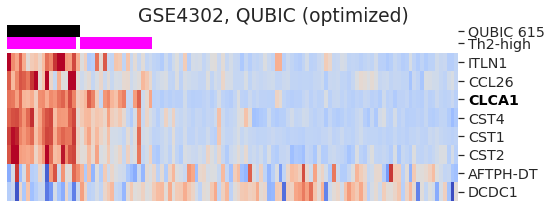

In [18]:
a = anno.loc[:,["asthma","sample type:ch1","Th2 asthma"]]
a.loc[a["asthma"]==1,"asthma"] = "Asthma"
a.loc[a["asthma"]==0,"asthma"] = "Healthy"

a = a.loc[:,["Th2 asthma"]]
a.columns = ["Th2-high"]
a.loc[a["Th2-high"]==1,"Th2-high"] = "Th2-high"
a.loc[a["Th2-high"]==0,"Th2-high"] = "Th2-low"

sns.set(font_scale=1.3)
# selecting colors
color_dict = OrderedDict()

color_dict["Th2-high"] = OrderedDict()
color_dict["Th2-high"]["Th2-high"] = "magenta"
color_dict["Th2-high"]["Th2-low"] = "white"

plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(exprs.loc[sorted(genes),:],
                                                            qubic_biclusters.loc[[bm_id],:],
                 annot=a,
                 color_dict=color_dict,
                 figsize = (8,3),
                 dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0,0.07),
                 legend_n_cols=0,no_cbar=True,
                 cluster_rows=True,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 highlight_row_labels=["POSTN","CLCA1","SERPINB2"],
                 bic_prefix = "QUBIC ")
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
tmp = sns_plot.fig.suptitle('GSE4302, QUBIC (optimized)')
fig_name = "Fig3_X_GSE4302_QUBIC"
for ext in ["png","pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

# GSE89809 
### UnPaSt

In [19]:
exprs_file = data_path + "/asthma_GSE89809_epithelial.RMA.maxRowVariance.log2exprs.tsv.gz"
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

anno  = pd.read_csv(data_path+"/asthma_GSE89809_epithelial.annot.tsv.gz",sep="\t",index_col=0)

known_groups = {"Th2 asthma":{"Th2-high": set(anno.loc[anno["Th2 asthma"]==1,:].index.values)}}

In [20]:
exprs.shape

(18311, 56)

In [21]:
unpast_biclusters = read_bic_table(bic_path+"/GSE89809/UnPaSt/optimized_ARI/asthma_GSE89809.seed=42.consensus.biclusters.tsv")

performance, best_matches = calculate_perfromance(unpast_biclusters, 
                                                  known_groups, 
                                                  set(anno.index.values),
                                                  adjust_pvals="BH",
                                                  performance_measure = "ARI")
print("Performance:",performance[0])
best_matches


Performance: 0.7831907772406099


,ARI,adj_pval,bm_id,is_enriched,n_samples,samples,weight,classification
Th2-high,0.783191,0.000007,143,True,14,"{GSM2389890, GSM2389885, GSM2389886, GSM238989...",1.0,Th2 asthma


In [22]:
bm_id = best_matches.loc[:,"bm_id"][0]
genes = unpast_biclusters.loc[bm_id,"genes"]
bm_id

143

<Figure size 432x288 with 0 Axes>

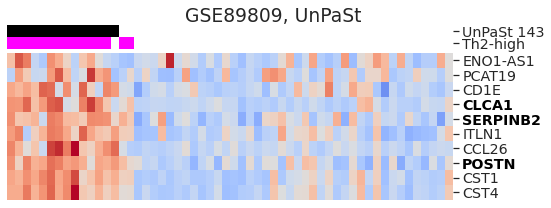

In [23]:
sns.set(font_scale=1.3)
a = anno.loc[:,["Th2 asthma"]]
a.columns = ["Th2-high"]
a.loc[a["Th2-high"]==1,"Th2-high"] = "Th2-high"
a.loc[a["Th2-high"]==0,"Th2-high"] = "Th2-low"

# selecting colors
color_dict = OrderedDict()

color_dict["Th2-high"] = OrderedDict()
color_dict["Th2-high"]["Th2-high"] = "magenta"
color_dict["Th2-high"]["Th2-low"] = "white"

plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(zscore(exprs),
                                                            unpast_biclusters.loc[[bm_id],:],
                 annot=a,
                 color_dict=color_dict,
                 figsize = (8,3),
                 dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0,0.07),
                 legend_n_cols=0,
                 no_cbar=True,
                 cluster_rows=True,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 bic_prefix = "UnPaSt ",
                 highlight_row_labels=["POSTN","CLCA1","SERPINB2"],)
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
tmp = sns_plot.fig.suptitle('GSE89809, UnPaSt') 
fig_name = "Fig3_x_GSE89809_UnPaSt"
for ext in ["png","pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

In [24]:
bm_id = best_matches["bm_id"].values[0]
" ".join(sorted(unpast_biclusters.loc[bm_id,"genes"]))

'CCL26 CD1E CLCA1 CST1 CST4 ENO1-AS1 ITLN1 PCAT19 POSTN SERPINB2'

In [25]:
" ".join(sorted(unpast_biclusters.loc[bm_id,"samples"]))

'GSM2389883 GSM2389885 GSM2389886 GSM2389888 GSM2389890 GSM2389891 GSM2389892 GSM2389893 GSM2389894 GSM2389919 GSM2389921 GSM2389923 GSM2389926 GSM2389927'

In [29]:
cseed = 42
n_runs = 5
seeds = []
random.seed(cseed)
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
    seed = seeds[i]
    fname = "asthma_GSE89809.seed="+str(seed)+".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"
    unpast_biclusters = read_bic_table(bic_path+"/GSE89809/UnPaSt/optimized_ARI/"+fname)
    
    
    performance, best_matches = calculate_perfromance(unpast_biclusters, 
                                                      known_groups, 
                                                      set(anno.index.values),
                                                      adjust_pvals="BH",
                                                      performance_measure = "ARI")
    bm_id = best_matches["bm_id"].values[0]
    print("\t".join([str(seed),str(performance[0]),
                     " ".join(sorted(unpast_biclusters.loc[bm_id,"genes"])),
                    ]))

670487	0.7831907772406099	CCL26 CD1E CLCA1 CST1 CST4 ENO1-AS1 ITLN1 POSTN SERPINB2
116739	0.7831907772406099	CCL26 CD1E CLCA1 CST1 CST4 ITLN1 PCAT19 PTER SERPINB2
26225	0.7831907772406099	CCL26 CD1E CLCA1 CST1 CST4 ITLN1 POSTN SERPINB2 SLC45A3
777572	0.7831907772406099	CCL26 CD1E CLCA1 CST1 CST4 ENO1-AS1 ITLN1 NKG7 PCAT19 SERPINB2
288389	0.718461876510657	CCL26 CST1 CST4 ENO1-AS1 ITLN1 PCAT19 POSTN SERPINB2


### QUBIC

In [30]:
qubic_biclusters = pd.read_csv(bic_path+"/GSE89809/QUBIC/optimized_ARI/GSE89809_r=1-q=0.04-c=0.75-f=1-type=area-biclusters_df.tsv",sep = "\t",index_col=0)
qubic_biclusters['genes'] = qubic_biclusters['genes'].apply(lambda row: eval(row))
qubic_biclusters['samples'] = qubic_biclusters['samples'].apply(lambda row: eval(row))
qubic_biclusters['n_samples'] = qubic_biclusters['samples'].apply(lambda x: len(x)) 
qubic_biclusters = qubic_biclusters.loc[qubic_biclusters["n_samples"] > 5, :]
qubic_biclusters.head(3)

,samples,genes,n_samples
1,"{GSM2389953, GSM2389849, GSM2389890, GSM238993...","{TBC1D28, GUK1, HNRNPA1P31, NOP10, DELEC1, CNR...",7
4,"{GSM2389953, GSM2389849, GSM2389931, GSM238993...","{TBC1D28, FAT3, GUK1, HNRNPA1P31, DELEC1, CNRI...",6
5,"{GSM2389849, GSM2389852, GSM2389931, GSM238988...","{TBC1D28, FAT3, SLC26A7, ARHGAP6, HNRNPA1P31, ...",6


In [32]:
performance, best_matches2 = calculate_perfromance(qubic_biclusters,
                                                   known_groups, 
                                                   set(anno.index.values),
                                                   adjust_pvals="BH",
                                                   performance_measure = "ARI"
                                                  )
print("Performance:",performance[0])
best_matches2

Performance: 0.7089455272363818


,ARI,adj_pval,bm_id,is_enriched,n_samples,samples,weight,classification
Th2-high,0.708946,0.000013,62,True,11,"{GSM2389893, GSM2389885, GSM2389886, GSM238992...",1.0,Th2 asthma


In [33]:
bm_id = best_matches2["bm_id"].values[0]
" ".join(sorted(qubic_biclusters.loc[bm_id,"samples"]))

'GSM2389883 GSM2389885 GSM2389886 GSM2389888 GSM2389891 GSM2389893 GSM2389894 GSM2389919 GSM2389923 GSM2389926 GSM2389927'

In [34]:
" ".join(sorted(qubic_biclusters.loc[bm_id,"genes"]))

'CCL26 CLCA1 CST1 CST2 CST4 NOS2 SERPINB10'

In [35]:
bm_id = best_matches2.loc[:,"bm_id"][0]
qubic_biclusters['genes_up'] = qubic_biclusters["genes"]
qubic_biclusters['genes_down'] = [set([])]*qubic_biclusters.shape[0]
genes = qubic_biclusters.loc[bm_id,"genes"]

bm_id

62

<Figure size 432x288 with 0 Axes>

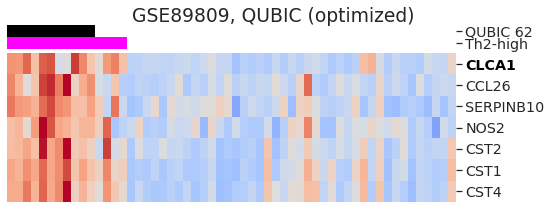

In [36]:
a = anno.loc[:,["Th2 asthma"]]
a.columns = ["Th2-high"]
a.loc[a["Th2-high"]==1,"Th2-high"] = "Th2-high"
a.loc[a["Th2-high"]==0,"Th2-high"] = "Th2-low"

# selecting colors
color_dict = OrderedDict()

color_dict["Th2-high"] = OrderedDict()
color_dict["Th2-high"]["Th2-high"] = "magenta"
color_dict["Th2-high"]["Th2-low"] = "white"

plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(zscore(exprs),
                                                            qubic_biclusters.loc[[bm_id],:],
                 annot=a,
                 color_dict=color_dict,
                 figsize = (8,3),
                 dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0,0.07),
                 legend_n_cols=0,
                 no_cbar=True,
                 cluster_rows=True,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 highlight_row_labels=["POSTN","CLCA1","SERPINB2"],
                 bic_prefix = "QUBIC ")
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
tmp = sns_plot.fig.suptitle('GSE89809, QUBIC (optimized)')
fig_name = "Fig3_x_GSE89809_QUBIC"
for ext in ["png","pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

# All methods
### GSE4302

In [38]:
exprs_file = data_path+"/asthma_GSE4302.RMA.maxRowVariance.log2exprs.tsv.gz"
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

anno  = pd.read_csv(data_path+"/asthma_GSE4302.annot.tsv.gz",sep="\t",index_col=0)

known_groups = {"Th2 asthma":{"Th2-high": set(anno.loc[anno["Th2 asthma"]==1,:].index.values)}}

all_samples = set(exprs.columns).intersection(set(anno.index))
print(len(all_samples))

118


In [39]:
stats = []
ds = "GSE4302"
fpath = bic_path+ds+"/"
for params  in ["optimized_ARI" ,"default"]:
    for method in os.listdir(fpath):
        for f in os.listdir(fpath+method+"/"+params+"/"):
            try:
                df = pd.read_csv(fpath+method+"/"+params+"/"+f,sep="\t",index_col=0,comment="#")
                df = df.loc[df["n_samples"]>1,:]
                if df.shape[0]>0:
                    df["samples"] = df["samples"].apply(lambda row: set([ x.replace("'","").replace(",","").replace('"','') for x in row.replace("{","").replace("}","").split(" ") if len(x)>0])) 
                    df["n_samples"] = df["samples"].apply(lambda x: len(x))
                    performance, best_matches = calculate_perfromance(df,
                                                                      known_groups,
                                                                      all_samples, 
                                                                      adjust_pvals = "BH",
                                                                      pval_cutoff=0.05,
                                                                      performance_measure = "ARI")
                    #print(best_matches)
                    ari = performance["Th2 asthma"]
                    #print(method,params,J)
                    stats.append({"method":method,
                                  "dataset":ds,
                                  "parameters":params,
                                 "ARI":ari})
                else:
                    #print(method,params,0,"0 clusters")
                    stats.append({"method":method,
                                  "dataset":ds,
                                  "parameters":params})
            except:
                #print(method,params,0,"file not opened ->No clusters")
                stats.append({"method":method,
                                  "dataset":ds,
                                  "parameters":params})
stats = pd.DataFrame.from_records(stats)
stats.sort_values("ARI",ascending =False).head(10)

,method,dataset,parameters,ARI
24,UnPaSt,GSE4302,optimized_ARI,0.865552
27,UnPaSt,GSE4302,optimized_ARI,0.865552
23,UnPaSt,GSE4302,optimized_ARI,0.865552
25,UnPaSt,GSE4302,optimized_ARI,0.865070
22,UnPaSt,GSE4302,optimized_ARI,0.865070
26,UnPaSt,GSE4302,optimized_ARI,0.865070
35,AP,GSE4302,optimized_ARI,0.133600
34,AP,GSE4302,optimized_ARI,0.133600
113,AP,GSE4302,default,0.133600
112,AP,GSE4302,default,0.133600


In [42]:
tool_order = ["UnPaSt", "bimax", "coalesce", "fabia", "isa2", "plaid", "qubic",
              "sparse_PCA","iClusterPlus","moCluster","MOFA2","NMF"]
d = "/home/olya/TUM/DESMOND/DESMOND2/bicluster_examples/asthma_biclustering_examples/"
dataset = "GSE4302"

stats = []
for method in tool_order:
    for params in ["default","optimized_ARI"]:
        print("####", method, params)
        jaccrds = []
        i = len(stats)
        for fname in os.listdir(d+method+"/"+params+"/"):
            if not fname.startswith(".") and not "seed=42.consensus" in fname:
                if dataset in fname:
                    
                    J = 0
                    if method == "UnPaSt":
                        df_clusters = read_bic_table(d+method+"/"+params+"/"+fname)
                        performance, best_matches = calculate_perfromance(df_clusters, known_groups, 
                                                                          all_samples, 
                                                                          adjust_pvals = "BH",
                                                                          pval_cutoff=0.05,
                                                                          performance_measure = "ARI") #, performance_measure = "ARI"
                        #print(best_matches)
                        J = performance["Th2 asthma"]
                        jaccrds.append(J)
                        print(fname,df_clusters.shape[0],J)
                    else:
                        try:
                            df_clusters = pd.read_csv(d+method+"/"+params+"/"+fname, sep ="\t")
                            df_clusters["samples"] = df_clusters["samples"].apply(lambda row: set([ x.replace("'","").replace(",","").replace('"','') for x in row.replace("{","").replace("}","").split(" ") if len(x)>0])) 
                            df_clusters["n_samples"] = df_clusters["samples"].apply(lambda x: len(x))
                            if "genes" in df_clusters.columns:
                                df_clusters["genes"] = df_clusters["genes"].apply(lambda row: set([ x.replace("'","").replace(",","").replace('"','') for x in row.replace("{","").replace("}","").split(" ") if len(x)>0]))
                                df_clusters["n_genes"] = df_clusters["genes"].apply(lambda x: len(x))
                            if "n_samples" in df_clusters.columns:
                                df_clusters = df_clusters.loc[df_clusters["n_samples"] > 5,:]
                                df_clusters = df_clusters.loc[df_clusters["n_samples"] < len(all_samples)-5,:]

                            if df_clusters.shape[0]>0:
                                performance, best_matches = calculate_perfromance(df_clusters, 
                                                                                  known_groups, 
                                                                                  all_samples, 
                                                                                  adjust_pvals = "BH",
                                                                                  pval_cutoff=0.05,
                                                                                 performance_measure = "ARI")
                                #print(best_matches)
                                J = performance["Th2 asthma"]
                                jaccrds.append(J)
                            else:
                                print(method,params,"No clusters")



                        except:
                            print(method,params,"no file or not parsed", fname)
                            df_clusters  = pd.DataFrame()
                    stats.append({"dataset":dataset, "method":method,"parameters":params,
                                  "run":i,"performance":J,"fname":fname})
                    i+=1
                    
        print(method, params,jaccrds)
        print("#### ")
        print()  


#### UnPaSt default
UnPaSt default []
#### 

#### UnPaSt optimized_ARI
asthma_GSE4302.seed=116739.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv 93 0.8650702286636647
asthma_GSE4302.seed=670487.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv 82 0.8655521881328333
asthma_GSE4302.seed=26225.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv 86 0.8655521881328333
asthma_GSE4302.seed=777572.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv 80 0.8650702286636647
asthma_GSE4302.seed=288389.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv 77 0.8655521881328333
UnPaSt optimized_ARI [0.8650702286636647, 0.8655521881328333, 0.8655521881328333, 0.8650702286636647, 0.8655521881328333]
#### 

#### b

# GSE89809


In [44]:
exprs_file = data_path+"/asthma_GSE89809_epithelial.RMA.maxRowVariance.log2exprs.tsv.gz"
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

anno  = pd.read_csv(data_path+"/asthma_GSE89809_epithelial.annot.tsv.gz",sep="\t",index_col=0)
anno.head(3)

known_groups = {"Th2 asthma":{"Th2-high": set(anno.loc[anno["Th2 asthma"]==1,:].index.values)}}
known_groups["Th2 asthma"].keys()
all_samples = set(exprs.columns).intersection(set(anno.index))
print(len(all_samples))

56


In [47]:
len(known_groups["Th2 asthma"]["Th2-high"])

15

In [48]:
stats2 = []
ds= "GSE89809"
fpath = bic_path+ds+"/"
for params  in ["optimized_ARI" ,"default"]:
    for method in os.listdir(fpath):
        for f in os.listdir(fpath+method+"/"+params+"/"):
            try:
                df = pd.read_csv(fpath+method+"/"+params+"/"+f,sep="\t",index_col=0,comment="#")
                if df.shape[0]>0:
                    df["samples"] = df["samples"].apply(lambda row: set([ x.replace("'","").replace(",","").replace('"','') for x in row.replace("{","").replace("}","").split(" ") if len(x)>0])) 
                    df["n_samples"] = df["samples"].apply(lambda x: len(x))
                    performance, best_matches = calculate_perfromance(df,
                                                                      known_groups,
                                                                      all_samples, 
                                                                      adjust_pvals = "BH",
                                                                      pval_cutoff=0.05,
                                                                      performance_measure = "ARI")
                    #print(best_matches)
                    ari = performance["Th2 asthma"]
                    #print(method,params,J)
                    stats2.append({"method":method,
                                  "dataset":ds,
                                  "parameters":params,
                                 "ARI":ari})
                else:
                    #print(method,params,0,"0 clusters")
                    stats2.append({"method":method,
                                  "dataset":ds,
                                  "parameters":params})
            except:
                #print(method,params,0,"file not opened ->No clusters")
                stats2.append({"method":method,
                                  "dataset":ds,
                                  "parameters":params})
stats2 = pd.DataFrame.from_records(stats2)
stats2

bicluster 1 elements set() are not in 'all_elements'
bicluster 1 elements set() are not in 'all_elements'
bicluster 1 elements set() are not in 'all_elements'
bicluster 1 elements set() are not in 'all_elements'
bicluster 1 elements set() are not in 'all_elements'


,method,dataset,parameters,ARI
0,mclust,GSE89809,optimized_ARI,0.0
1,mclust,GSE89809,optimized_ARI,0.0
2,mclust,GSE89809,optimized_ARI,0.0
3,mclust,GSE89809,optimized_ARI,0.0
4,mclust,GSE89809,optimized_ARI,0.0
...,...,...,...,...
157,MB-k-means,GSE89809,default,0.0
158,MB-k-means,GSE89809,default,0.0
159,MB-k-means,GSE89809,default,0.0
160,MB-k-means,GSE89809,default,0.0


In [49]:
df = pd.concat([stats,stats2]).sort_values("ARI",ascending = False)
df.to_csv("tmp_asthma_performances_Fig3.tsv.gz",sep ="\t")
df

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

In [50]:
d = "/home/olya/TUM/DESMOND/DESMOND2/bicluster_examples/asthma_biclustering_examples/"
dataset = "GSE89809"

for method in tool_order:
    for params in ["default","optimized_ARI"]:
        print("####", method, params)
        jaccrds = []
        i = len(stats)
        for fname in os.listdir(d+method+"/"+params+"/"):
            if not fname.startswith(".") and not "seed=42.consensus" in fname:
                if dataset in fname:
                    
                    J = 0
                    if method == "UnPaSt":
                        df_clusters = read_bic_table(d+method+"/"+params+"/"+fname)
                        performance, best_matches = calculate_perfromance(df_clusters, known_groups, all_samples,
                                                                          adjust_pvals = "BH",pval_cutoff=0.05,
                                                                          performance_measure = "ARI")
                        #print(best_matches)
                        J = performance["Th2 asthma"]
                        jaccrds.append(J)
                        print(fname,df_clusters.shape[0],J)
                        #print(" ".join(sorted(df_clusters.loc[best_matches.loc["Th2-high","bm_id"],"genes"])))
                    else:
                        try:
                            df_clusters = pd.read_csv(d+method+"/"+params+"/"+fname, sep ="\t")
                            df_clusters["samples"] = df_clusters["samples"].apply(lambda row: set([ x.replace("'","").replace(",","").replace('"','') for x in row.replace("{","").replace("}","").split(" ") if len(x)>0])) 
                            df_clusters["n_samples"] = df_clusters["samples"].apply(lambda x: len(x))
                            if "genes" in df_clusters.columns:
                                df_clusters["genes"] = df_clusters["genes"].apply(lambda row: set([ x.replace("'","").replace(",","").replace('"','') for x in row.replace("{","").replace("}","").split(" ") if len(x)>0]))
                                df_clusters["n_genes"] = df_clusters["genes"].apply(lambda x: len(x))
                            if "n_samples" in df_clusters.columns:
                                df_clusters = df_clusters.loc[df_clusters["n_samples"] > 5,:]
                                df_clusters = df_clusters.loc[df_clusters["n_samples"] < len(all_samples)-5,:]


                            if "n_samples" in df_clusters.columns:
                                df_clusters = df_clusters.loc[df_clusters["n_samples"] > 5,:]
                                df_clusters = df_clusters.loc[df_clusters["n_samples"] < len(all_samples)-5,:]
                            if df_clusters.shape[0]>0:
                                performance, best_matches = calculate_perfromance(df_clusters, known_groups, all_samples,
                                                                                  adjust_pvals = "BH",pval_cutoff=0.05, 
                                                                                  performance_measure = "ARI")
                                #print(best_matches)
                                J = performance["Th2 asthma"]
                                jaccrds.append(J)
                            else:
                                print(method,params,"No clusters")



                        except:
                            print(method,params,"no file or not parsed", fname)
                            df_clusters  = pd.DataFrame()
                    stats.append({"dataset":dataset, "method":method,"parameters":params,
                                  "run":i,"performance":J,"fname":fname})
                    i+=1
                    
        print(method, params,jaccrds)
        print("#### ")
        print()            

#### UnPaSt default
UnPaSt default []
#### 

#### UnPaSt optimized_ARI
asthma_GSE89809.seed=116739.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv 113 0.7831907772406099
asthma_GSE89809.seed=26225.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv 108 0.7831907772406099
asthma_GSE89809.seed=670487.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv 123 0.7831907772406099
asthma_GSE89809.seed=288389.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv 109 0.718461876510657
asthma_GSE89809.seed=777572.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv 112 0.7831907772406099
UnPaSt optimized_ARI [0.7831907772406099, 0.7831907772406099, 0.7831907772406099, 0.718461876510657, 0.7831907772406099]
#### 

### plots

In [51]:
stats = pd.DataFrame.from_records(stats)
stats.loc[stats["method"]=="coalesce","method"] = "COALESCE"
stats.loc[stats["method"]=="bimax","method"] = "BiMax"
stats.loc[stats["method"]=="fabia","method"] = "FABIA"
stats.loc[stats["method"]=="isa2","method"] = "ISA2"
stats.loc[stats["method"]=="qubic","method"] = "QUBIC"
stats.loc[stats["method"]=="plaid","method"] = "Plaid"
stats.loc[stats["method"]=="sparse_PCA","method"] = "sparse PCA"
stats.loc[stats["parameters"]=="optimized_ARI","parameters"] = "optimized"
stats

,dataset,method,parameters,run,performance,fname
0,GSE4302,UnPaSt,optimized,0,0.865070,"asthma_GSE4302.seed=116739.bin=kmeans,pval=0.0..."
1,GSE4302,UnPaSt,optimized,1,0.865552,"asthma_GSE4302.seed=670487.bin=kmeans,pval=0.0..."
2,GSE4302,UnPaSt,optimized,2,0.865552,"asthma_GSE4302.seed=26225.bin=kmeans,pval=0.01..."
3,GSE4302,UnPaSt,optimized,3,0.865070,"asthma_GSE4302.seed=777572.bin=kmeans,pval=0.0..."
4,GSE4302,UnPaSt,optimized,4,0.865552,"asthma_GSE4302.seed=288389.bin=kmeans,pval=0.0..."
...,...,...,...,...,...,...
73,GSE89809,sparse PCA,default,73,0.000000,GSE89809_sparse_PCA_2.tsv
74,GSE89809,sparse PCA,default,74,0.000000,GSE89809_sparse_PCA_3.tsv
75,GSE89809,sparse PCA,default,75,0.000000,GSE89809_sparse_PCA_4.tsv
76,GSE89809,sparse PCA,default,76,0.000000,GSE89809_sparse_PCA_5.tsv


In [51]:
# removing rows
stats = stats.loc[stats["method"]!="BiMax",:]
stats = stats.loc[stats["method"]!="FABIA",:]
stats = stats.loc[stats["method"]!="Plaid",:]

In [52]:
palette = ["#ff0000","#de8f05","#de8f05","#de8f05","#0173b2",]

In [75]:
figsizes = (8,3)
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
#sns.set()
sns.set_style("whitegrid")

plt.figure(figsize=figsizes)
sns_plot2 = sns.barplot(data=stats.loc[stats['dataset']=="GSE4302",:], 
                        x="method",y="performance", hue="parameters",
                         capsize=0.1, 
            hue_order=['default', 'optimized'],palette=["grey"]*5)

#sns_plot2.legend_.remove()
plt.legend(loc='upper right')
# Set plot title and labels
plt.title('$\mathbf{{GSE4302}}$, 37 of 118 samples express Th2-high signature')
plt.ylim(0,1)
tmp = plt.ylabel('Performance (ARI)', fontsize=16)
tmp = plt.xlabel('')
tmp = plt.xticks(fontsize=12)

# sub_fig is the returned ax and palette is a list of colors for each element on the x-axis
for bars, hatch, legend_handle in zip(sns_plot2.containers, ['', '//'], sns_plot2.legend_.legendHandles):
    for bar, color in zip(bars, palette):
        bar.set_facecolor(color)
        bar.set_hatch(hatch)
    # update the existing legend, use twice the hatching pattern to make it denser
    #legend_handle.set_color("grey")
    legend_handle.set_hatch(hatch+hatch)
    
fig_name = "Fig3_x_GSE4302"
for ext in ["png","pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

ValueError: Could not interpret input 'performance'

<Figure size 576x216 with 0 Axes>

<ipython-input-58-c8a3c2bfbc9a>:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for bars, hatch, legend_handle in zip(sns_plot1.containers, ['', '//'], sns_plot1.legend_.legendHandles):


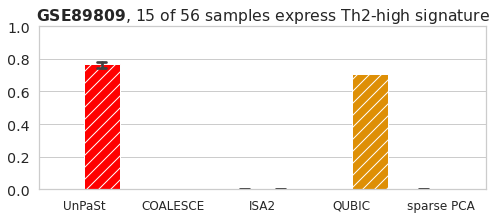

In [58]:
plt.figure(figsize=figsizes)
sns_plot1 = sns.barplot(data=stats.loc[stats['dataset']=="GSE89809",:], 
                        x="method",y="performance", hue="parameters",
                         capsize=0.1, 
            hue_order=['default', 'optimized'],palette=["grey"]*5)
# Set plot title and labels
plt.ylim(0,1)
plt.title('$\mathbf{{GSE89809}}$, 15 of 56 samples express Th2-high signature')
plt.ylabel('')
tmp = plt.xlabel('')
tmp = plt.xticks(fontsize=12)

# sub_fig is the returned ax and palette is a list of colors for each element on the x-axis
for bars, hatch, legend_handle in zip(sns_plot1.containers, ['', '//'], sns_plot1.legend_.legendHandles):
    for bar, color in zip(bars, palette):
        bar.set_facecolor(color)
        bar.set_hatch(hatch)
    # update the existing legend, use twice the hatching pattern to make it denser
    #legend_handle.set_color("grey")
    legend_handle.set_hatch(hatch+hatch)
    
sns_plot1.legend_.remove()
fig_name = "Fig3_x_GSE489809"
for ext in ["png","pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

In [88]:
stats

,dataset,method,parameters,run,performance,fname
0,GSE4302,UnPaSt,optimized,0,0.865070,"asthma_GSE4302.seed=116739.bin=kmeans,pval=0.0..."
1,GSE4302,UnPaSt,optimized,1,0.865552,"asthma_GSE4302.seed=670487.bin=kmeans,pval=0.0..."
2,GSE4302,UnPaSt,optimized,2,0.865552,"asthma_GSE4302.seed=26225.bin=kmeans,pval=0.01..."
3,GSE4302,UnPaSt,optimized,3,0.865070,"asthma_GSE4302.seed=777572.bin=kmeans,pval=0.0..."
4,GSE4302,UnPaSt,optimized,4,0.865552,"asthma_GSE4302.seed=288389.bin=kmeans,pval=0.0..."
8,GSE4302,COALESCE,default,8,0.000000,GSE4302_prob_gene=0.95-pvalue_cond=0.05-pvalue...
9,GSE4302,COALESCE,optimized,9,0.193605,GSE4302_prob_gene=0.9-pvalue_cond=0.01-pvalue_...
20,GSE4302,ISA2,default,20,0.418372,GSE4302_no_seeds=100-run3-biclusters_df.tsv
21,GSE4302,ISA2,default,21,0.229474,GSE4302_no_seeds=100-run2-biclusters_df.tsv
22,GSE4302,ISA2,default,22,0.340092,GSE4302_no_seeds=100-run4-biclusters_df.tsv


# UnPaSt - sex specific biclusters

In [76]:
exprs_file = data_path+"asthma_GSE4302.RMA.maxRowVariance.log2exprs.tsv.gz"
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

anno  = pd.read_csv(data_path+"asthma_GSE4302.annot.tsv.gz",sep="\t",index_col=0)
anno.head(3)
all_samples = set(exprs.columns).intersection(set(anno.index))

#unpast_biclusters = read_bic_table("../../results_on_real_data_tuned_v2/optimized_GSE4302/asthma_GSE4302.seed=42.consensus.biclusters.tsv")
unpast_biclusters = read_bic_table("../../bicluster_examples/asthma_biclustering_examples/UnPaSt/optimized//asthma_GSE4302.seed=42.consensus.biclusters.tsv")

In [77]:
set(anno["sample type:ch1"].values)

{'Asthmatic after Flovent',
 'Asthmatic after Placebo',
 'Asthmatic at baseline',
 'Healthy control',
 'Smoker'}

<Figure size 432x288 with 0 Axes>

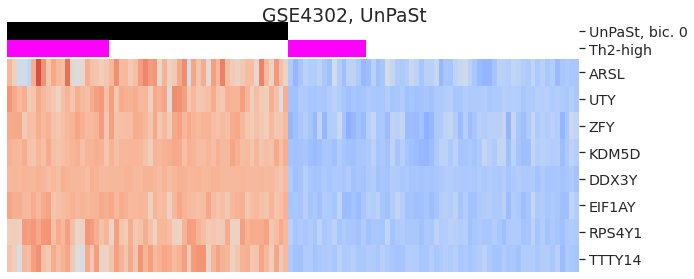

In [78]:
a = anno.loc[:,["asthma","sample type:ch1","Th2 asthma","is_smoker"]]
a.loc[a["asthma"]==1,"asthma"] = "Asthma"
a.loc[a["asthma"]==0,"asthma"] = "Healthy"
a.loc[a["sample type:ch1"]=="Smoker","asthma"] = "Smoker"
a.loc[a["sample type:ch1"]=="Healthy","asthma"] = "Healthy"
#a = a.loc[:,["asthma","sample type:ch1","Th2 asthma"]]
#a.columns = ["asthma","patient group","Th2-high"]
a = a.loc[:,["asthma","Th2 asthma","is_smoker"]]
a.columns = ["patient group","Th2-high","smoker"]
a.loc[a["Th2-high"]==1,"Th2-high"] = "Th2-high"
a.loc[a["Th2-high"]==0,"Th2-high"] = "Th2-low"

sns.set(font_scale=1.3)
# selecting colors
color_dict = OrderedDict()
color_dict["patient group"] = OrderedDict()
color_dict["patient group"]['Asthmatic after Flovent'] = "darkred"
color_dict["patient group"]['Asthma'] = "red"
color_dict["patient group"]['Asthmatic at baseline'] = "pink"
color_dict["patient group"]['Asthmatic after Placebo'] = "red"
color_dict["patient group"]['Healthy'] = "blue"
color_dict["patient group"]['Healthy control'] = "blue"
color_dict["patient group"]['Smoker'] = "grey"
color_dict["smoker"] = OrderedDict()
color_dict["smoker"][1] = "grey"
color_dict["smoker"][0] = "white"
color_dict["Th2-high"] = OrderedDict()
color_dict["Th2-high"]["Th2-high"] = "magenta"
color_dict["Th2-high"]["Th2-low"] = "white"

genes = sorted(unpast_biclusters.loc[0,"genes"])
plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(exprs.loc[genes,:],unpast_biclusters.loc[[0],:],
                 annot=a.loc[:,["Th2-high"]],
                 color_dict=color_dict,
                 figsize = (10,4),dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0,0.07),
                 no_cbar=True,
                 cluster_rows=True,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 bic_prefix = "UnPaSt, bic. ")
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
tmp = sns_plot.fig.suptitle('GSE4302, UnPaSt') 

fig_name = "FigSX_GSE4302_sex"
plt.savefig(img_path+fig_name+".png", dpi=300)
plt.savefig(img_path+fig_name+".svg")

AKR1B10 ALDH3A1 BPIFB2 CABYR CYP1B1 GPX2 HS3ST3A1 JAKMIP3 LINC00942 LINC01697 ME1 NOVA1 NR0B1 NRCAM PHEX SAMD5 SFRP2 SLC7A11 SPP1 UCHL1


<Figure size 432x288 with 0 Axes>

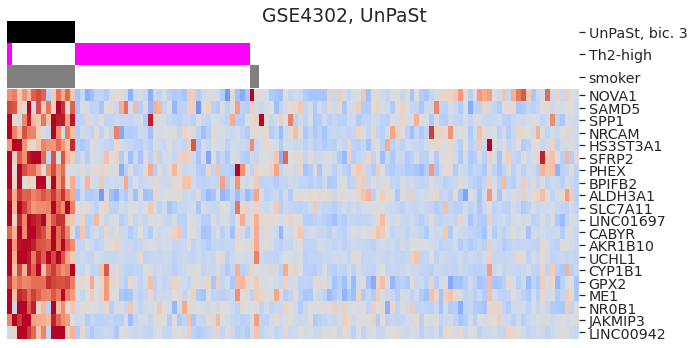

In [79]:
# smokers
bic_id = 3
genes = sorted(unpast_biclusters.loc[bic_id,"genes"])
print(" ".join(genes))
plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(exprs,
                                                            unpast_biclusters.loc[[bic_id],:],
                 annot=a.loc[:,["Th2-high","smoker"]],
                 color_dict=color_dict,
                 figsize = (10,5),dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0,0.07),
                 legend_n_cols=0,
                 no_cbar=True,
                 cluster_rows=True,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 bic_prefix = "UnPaSt, bic. ")
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
tmp = sns_plot.fig.suptitle('GSE4302, UnPaSt') 

fig_name = "FigSX_GSE4302_smokers"
plt.savefig(img_path+fig_name+".png", dpi=300)
plt.savefig(img_path+fig_name+".svg")

In [80]:
smoking_signature = ['AKR1B10', 'ALDH3A1', 'BPIFB2', 'CABYR', 'CYP1B1', 'GPX2', 'HS3ST3A1', 'JAKMIP3', 'LINC00942', 'LINC01697', 'ME1', 'NOVA1', 'NR0B1', 'NRCAM', 'PHEX', 'SAMD5', 'SFRP2', 'SLC7A11', 'SPP1', 'UCHL1']
print(" ".join(smoking_signature))
smoking_signature = sorted(unpast_biclusters.loc[3,"genes_up"])
len(smoking_signature)

AKR1B10 ALDH3A1 BPIFB2 CABYR CYP1B1 GPX2 HS3ST3A1 JAKMIP3 LINC00942 LINC01697 ME1 NOVA1 NR0B1 NRCAM PHEX SAMD5 SFRP2 SLC7A11 SPP1 UCHL1


20

In [81]:
" ".join(sorted(unpast_biclusters.loc[15,"genes"]))

'CCL26 CLC CLCA1 CST1 CST2 CST4 ITLN1 SERPINB10 TIMM8A UTP20 ZMAT4'

<Figure size 432x288 with 0 Axes>

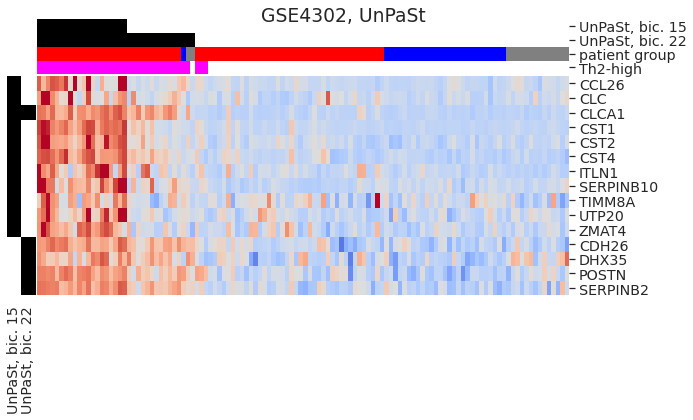

In [82]:
genes = sorted(unpast_biclusters.loc[15,"genes"]| unpast_biclusters.loc[22,"genes"])
plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(exprs,
                 unpast_biclusters.loc[[15,22],:],
                 annot=a.loc[:,["patient group","Th2-high"]],
                 color_dict=color_dict,
                 figsize = (10,6),dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0.025,0.05),
                 no_cbar=True,
                 cluster_rows=False,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 bic_prefix = "UnPaSt, bic. ",
                no_row_colors = False)
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
tmp = sns_plot.fig.suptitle('GSE4302, UnPaSt') 

fig_name = "FigSX_GSE4302_15_and_22"
plt.savefig(img_path+fig_name+".png", dpi=300)
plt.savefig(img_path+fig_name+".svg")

### GSE89809

In [83]:
exprs_file = data_path+"asthma_GSE89809_epithelial.RMA.maxRowVariance.log2exprs.tsv.gz"
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

anno  = pd.read_csv(data_path+"asthma_GSE89809_epithelial.annot.tsv.gz",sep="\t",index_col=0)
anno.head(3)
all_samples = set(exprs.columns).intersection(set(anno.index))
unpast_biclusters = read_bic_table("../../bicluster_examples/asthma_biclustering_examples/UnPaSt/optimized//asthma_GSE89809.seed=42.consensus.biclusters.tsv")
unpast_biclusters.head(3)

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times
id,,,,,,,,,,,
0,8.054910,15,5,"{EMC3, SPSB3, MGST1, PARP4, BRCC3, NAPG, TNRC1...","{GSM2389953, GSM2389849, GSM2389890, GSM238993...",{},"{EMC3, SPSB3, MGST1, PARP4, BRCC3, NAPG, TNRC1...","{11328, 4545, 9600, 1539, 11460, 15333, 16357,...","{38, 10, 44, 49, 27}",DOWN,3
1,7.304411,26,5,"{PRCP, NEDD1, DNAH3, SIGIRR, SRRD, ANKZF1, ASF...","{GSM2389849, GSM2389890, GSM2389931, GSM238993...",{},"{PRCP, NEDD1, DNAH3, SIGIRR, SRRD, ANKZF1, ASF...","{4481, 15495, 1040, 12312, 15141, 3754, 12075,...","{38, 10, 43, 44, 27}",DOWN,4
2,7.138074,77,5,"{TMEM9B, SNAPC3, TIMM10, SEMA3C, TMTC3, DCDC1,...","{GSM2389953, GSM2389849, GSM2389931, GSM238993...",{},"{TMEM9B, SNAPC3, TIMM10, SEMA3C, TMTC3, DCDC1,...","{10756, 3594, 5133, 17940, 10262, 13342, 11298...","{38, 10, 43, 44, 49}",DOWN,5


In [84]:
set(anno["smoking"].values)

{'Current', 'Former', 'Never'}

<Figure size 432x288 with 0 Axes>

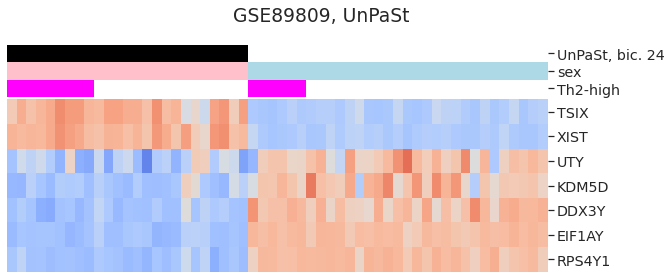

In [85]:
anno["sex"] = "F"
anno.loc[anno["is_female"]==0,"sex"] = "M"

a = anno.loc[:,["group","Th2 asthma","sex","smoking"]]
a.columns = ["patient group","Th2-high","sex","smoking"]
a.loc[a["patient group"]=="Mild", "patient group"] = "Asthma"
a.loc[a["patient group"]=="Moderate", "patient group"] = "Asthma"
a.loc[a["patient group"]=="Severe", "patient group"] = "Asthma"
a.loc[a["patient group"]=="Healthy", "patient group"] = "Healthy"
a.loc[a["Th2-high"]==1,"Th2-high"] = "Th2-high"
a.loc[a["Th2-high"]==0,"Th2-high"] = "Th2-low"

set(a["patient group"].values)
# selecting colors
color_dict = OrderedDict()
color_dict["patient group"] = OrderedDict()
color_dict["patient group"]['Asthma'] = "red"
color_dict["patient group"]['Healthy'] = "blue"
color_dict["sex"] = OrderedDict()
color_dict["sex"]["M"] = "lightblue"
color_dict["sex"]["F"] = "pink"
color_dict["smoking"] = OrderedDict()
color_dict["smoking"]['Former'] = "lightgrey"
color_dict["smoking"]['Current'] = "grey"
color_dict["smoking"]['Never'] = "white"
color_dict["Th2-high"] = OrderedDict()
color_dict["Th2-high"]["Th2-high"] = "magenta"
color_dict["Th2-high"]["Th2-low"] = "white"

genes = sorted(unpast_biclusters.loc[24,"genes"])
plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(zscore(exprs.loc[genes,:]),
                                                            unpast_biclusters.loc[[24],:],
                 annot=a.loc[:,["sex","Th2-high"]],
                 color_dict=color_dict,
                 figsize = (10,4),dendrogram_ratio=(0.05,0.1),
                 colors_ratio=(0,0.07),
                 #no_legend=False,
                 no_cbar=True,
                 cluster_rows=True,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 #col_range=(-3,3),
                 bic_prefix = "UnPaSt, bic. ")
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
tmp = sns_plot.fig.suptitle('GSE89809, UnPaSt') 

fig_name = "FigSX_GSE89809_sex"
plt.savefig(img_path+fig_name+".png", dpi=300)
plt.savefig(img_path+fig_name+".svg")

<Figure size 432x288 with 0 Axes>

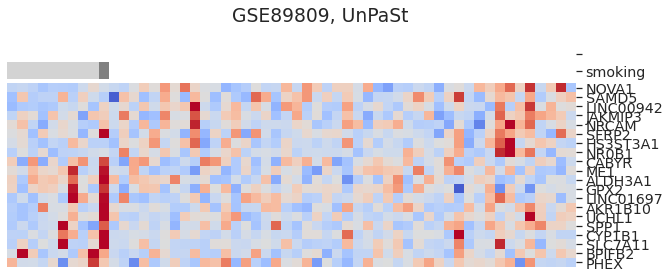

In [86]:
df = {" ":{"genes":set(smoking_signature),
                 "samples":set([]),
                 "genes_up":set(smoking_signature),
                 "genes_down":set([])
                }
     }
df = pd.DataFrame.from_dict(df).T

genes = smoking_signature

plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(zscore(exprs.loc[genes,:]),
                                                            df,
                 annot=a.loc[:,["smoking"]],
                 color_dict=color_dict,
                 figsize = (10,4),dendrogram_ratio=(0.05,0.1),
                 colors_ratio=(0,0.07),
                 no_cbar=True,
                 cluster_rows=True,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 bic_prefix = "")
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
tmp = sns_plot.fig.suptitle('GSE89809, UnPaSt') 

fig_name = "FigX_smokingGSE89809A"
plt.savefig(img_path+fig_name+".png", dpi=300)
plt.savefig(img_path+fig_name+".svg")

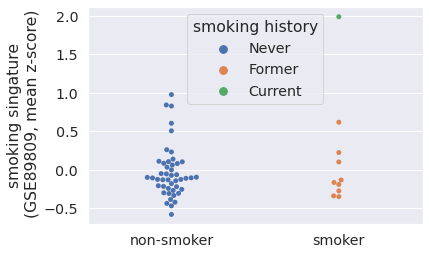

In [87]:
mean_smoking_z = zscore(exprs.loc[genes,:]).mean()
a = anno.loc[:,["smoking"]]
a.columns = ["smoking history"]
a["smoking singature\n (GSE89809, mean z-score)"] = mean_smoking_z
a["is smoker"] = "smoker"
a.loc[a["smoking history"]=="Never","is smoker"] = "non-smoker"
tmp = sns.swarmplot(data = a, x ="is smoker",
              y ="smoking singature\n (GSE89809, mean z-score)",hue="smoking history")
plt.xlabel("")
sns.set_style("whitegrid")
fig_name = "FigX_smokingGSE89809_swarmplot"
plt.savefig(img_path+fig_name+".png", dpi=300)
plt.savefig(img_path+fig_name+".svg")

In [88]:
" ".join(genes)

'AKR1B10 ALDH3A1 BPIFB2 CABYR CYP1B1 GPX2 HS3ST3A1 JAKMIP3 LINC00942 LINC01697 ME1 NOVA1 NR0B1 NRCAM PHEX SAMD5 SFRP2 SLC7A11 SPP1 UCHL1'